In [22]:
import requests
from tinkoff.invest import Client, CandleInterval, PortfolioResponse, RequestError, HistoricCandle
from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX, INVEST_GRPC_API
from datetime import datetime, timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
from ta import trend

In [6]:


SANDBOX_TOKEN = 't.s9IMPYkUcfM_hPRgYxaDwWDp_-lt46z-Uf89QtIjPyuCP0apNrBGUdL-Kjx4OiARatXVz4_y2aSdx0pYlzy1Hg'
READ_ONLY_TOKEN = 't.CTyNe4_y1XawpuclwUFIEc5Uw9wERdMIbD_njBdslJH-OQGKj9eyqDae1lTSy-eHsY0wNX3OKTnBgj8DHaXoRA'
API_HOST_SANDBOX = 'https://sandbox-invest-public-api.tinkoff.ru:443'
GET_SHARES = 'GetShares'
poly_figi = 'BBG004PYF2N3'

ACCOUNT_ID = '2032517688'

In [7]:
with Client(READ_ONLY_TOKEN, target=INVEST_GRPC_API) as client:
    # r = client.market_data.get_candles(
    #     figi=poly_figi,
    #     from_= datetime(2022, 1, 1),
    #     to=datetime.now(),
    #     interval=CandleInterval.CANDLE_INTERVAL_DAY
    # )
    r : PortfolioResponse = client.users.get_accounts()
    print(r)


GetAccountsResponse(accounts=[Account(id='2032517688', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='Брокерский счёт', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2020, 6, 19, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>), Account(id='2195611054', type=<AccountType.ACCOUNT_TYPE_INVEST_BOX: 3>, name='Инвесткопилка', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2022, 8, 22, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


In [8]:
def cast_money(v):
    """_summary_

    Args:
        v (MoneyValue): Данные из апи
    """
    return v.units + v.nano / 1e9

In [9]:
try:
    with Client(READ_ONLY_TOKEN, target=INVEST_GRPC_API) as client:
        r : PortfolioResponse = client.operations.get_portfolio(account_id=ACCOUNT_ID)
        # print(r)
        
        keys = ['total_amount_shares', 'total_amount_etf', 'total_amount_currencies']
        df = pd.DataFrame([cast_money(getattr(r, k)) for k in keys], index=keys)
        print(df)
except RequestError as e:
    print(str(e))
        

                                 0
total_amount_shares      659925.90
total_amount_etf           4211.10
total_amount_currencies     652.81


In [10]:
def create_df_candles(candles : [HistoricCandle]):
    df = pd.DataFrame([{
        'time'      : c.time,
        'volume'    : c.volume,
        'open'      : cast_money(c.open),
        'close'     : cast_money(c.close),
        'high'      : cast_money(c.high),
        'low'       : cast_money(c.low)
    } for c in candles])
    
    return df

In [29]:
df = pd.DataFrame()
try:
    with Client(READ_ONLY_TOKEN, target=INVEST_GRPC_API) as client:
        for year in range(2016, 2023):
            r = client.market_data.get_candles(
                figi=poly_figi,
                from_=datetime(year, 1, 1),
                to=datetime(year, 12, 31),
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            )
            df_cur = create_df_candles(r.candles)
            if df.empty:
                df = df_cur
            else:
                df = pd.concat([df, df_cur], ignore_index=True)
            #df['ema'] = trend.ema_indicator(close=df['close'], window=9)
        
except RequestError as e:
    print(str(e))

In [30]:
df

,time,volume,open,close,high,low
0,2015-12-31 07:00:00+00:00,13715,626.0,622.0,636.0,602.0
1,2016-01-01 07:00:00+00:00,13715,626.0,622.0,636.0,602.0
2,2016-01-04 07:00:00+00:00,1875,612.5,613.5,626.5,607.0
3,2016-01-05 07:00:00+00:00,4779,622.0,621.0,630.0,614.0
4,2016-01-06 07:00:00+00:00,6711,629.0,625.0,629.0,610.0
...,...,...,...,...,...,...
1795,2022-12-13 07:00:00+00:00,1882293,369.0,378.6,381.6,367.5
1796,2022-12-14 07:00:00+00:00,1723880,379.7,375.4,382.0,369.0
1797,2022-12-15 07:00:00+00:00,1716480,373.8,361.1,374.0,357.5
1798,2022-12-16 07:00:00+00:00,1433459,360.0,358.7,364.9,351.0


In [39]:
df_1 = df.copy()
df_1['ema'] = trend.ema_indicator(close=df['close'], window=100)

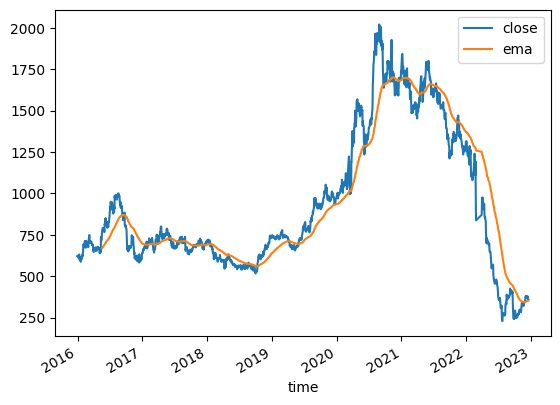

In [40]:
ax = df_1.plot(x='time', y='close')
df_1.plot(ax=ax, x='time', y='ema')
plt.show()

In [48]:
df.to_csv('../data/poly_data.csv')